(Coding source)[https://www.youtube.com/watch?v=PuZY9q-aKLw]


In [1]:
# Importing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import yfinance as yfin
yfin.pdr_override()

import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [4]:
# Create your connection.
import sqlite3
cnx = sqlite3.connect('db.sqlite')
df_covid = pd.read_sql('select * from casos_covid_raw', cnx)


In [8]:
df_casos = pd.read_sql('select * from casos_covid_semanal', cnx)

In [9]:
df_casos

,data,casosNovos
0,2020-03-01 00:00:00,2
1,2020-03-08 00:00:00,23
2,2020-03-15 00:00:00,175
3,2020-03-22 00:00:00,1346
4,2020-03-29 00:00:00,2710
...,...,...
161,2023-04-02 00:00:00,60591
162,2023-04-09 00:00:00,38838
163,2023-04-16 00:00:00,49140
164,2023-04-23 00:00:00,42186


In [5]:
# Load Data
company = 'Meta'

start = dt.datetime(2012,1,1)
end = dt.datetime(2020,1,1)

data = pdr.data.get_data_yahoo(company, start, end)


[*********************100%***********************]  1 of 1 completed


In [22]:
import math

TEST_PERCENTAGE = 80
test_limit = math.ceil((TEST_PERCENTAGE/100)*len(df_covid))
data = df_casos[:test_limit]
data

,data,casosNovos
0,2020-03-01 00:00:00,2
1,2020-03-08 00:00:00,23
2,2020-03-15 00:00:00,175
3,2020-03-22 00:00:00,1346
4,2020-03-29 00:00:00,2710
...,...,...
161,2023-04-02 00:00:00,60591
162,2023-04-09 00:00:00,38838
163,2023-04-16 00:00:00,49140
164,2023-04-23 00:00:00,42186


In [23]:
# Prepare Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['casosNovos'].values.reshape(-1, 1))
prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [24]:
# Build The Model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Prediction of the next closing values

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)


Epoch 1/25
4/4 [==============================] - 14s 82ms/step - loss: 0.0429
Epoch 2/25
4/4 [==============================] - 1s 146ms/step - loss: 0.0385
Epoch 3/25
4/4 [==============================] - 0s 87ms/step - loss: 0.0332
Epoch 4/25
4/4 [==============================] - 0s 106ms/step - loss: 0.0340
Epoch 5/25
4/4 [==============================] - 1s 151ms/step - loss: 0.0327
Epoch 6/25
4/4 [==============================] - 0s 85ms/step - loss: 0.0313
Epoch 7/25
4/4 [==============================] - 0s 92ms/step - loss: 0.0316
Epoch 8/25
4/4 [==============================] - 0s 82ms/step - loss: 0.0313
Epoch 9/25
4/4 [==============================] - 0s 90ms/step - loss: 0.0310
Epoch 10/25
4/4 [==============================] - 0s 76ms/step - loss: 0.0311
Epoch 11/25
4/4 [==============================] - 0s 94ms/step - loss: 0.0302
Epoch 12/25
4/4 [==============================] - 0s 82ms/step - loss: 0.0298
Epoch 13/25
4/4 [==============================] - 0s 97m

In [16]:
# Load Test Data
# test_start = dt.datetime(2020, 1, 1)
# test_end = dt.datetime.now()

# test_data = pdr.data.get_data_yahoo(company, test_start, test_end)
test_data = df_casos[test_limit:]
actual_prices = test_data['casosNovos'].values

total_dataset = pd.concat((data['casosNovos'], test_data['casosNovos']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

[*********************100%***********************]  1 of 1 completed


KeyError: 'casosNovos'

In [14]:
# Make Predictions on Test Data
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

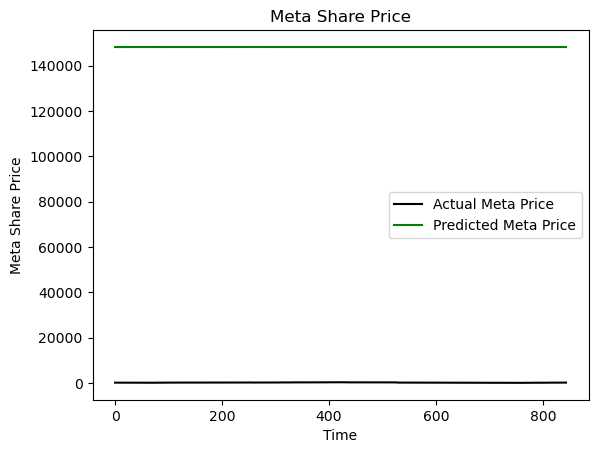

In [15]:
# Plot The Test Predictions
plt.plot(actual_prices, color='black', label=f'Actual {company} Price')
plt.plot(predicted_prices, color='green', label=f'Predicted {company} Price')
plt.title(f'{company} Share Price')
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()

904

In [43]:
len(model_inputs)
model_inputs.shape

(902, 1)

In [45]:
real_data.shape

(1, 59, 1)

In [52]:
(len(model_inputs) - prediction_days) - len(model_inputs+ 1)

-60

In [53]:
# Predict Next Day
real_data = [model_inputs[len(model_inputs) - prediction_days:len(model_inputs+ 1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f'Prediction: {prediction}')

Prediction: [[219.5899]]
